Esse notebook tem como objetivo o desenvolvimento de todos os modelos de behavior solicitados pela claro para avaliar se clientes pré-pago virariam ou não inadimplentes ao migrar para plano controle.


#BIBLIOTECAS E INSTALAÇÕES

In [166]:
#configurando ambiente spark:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [167]:
# manipulação, leitura e vizualização de dados bibiliotecas
import pandas as pd
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

In [168]:
# Configurar o Pandas para não usar notação científica para floats e exibir com 2 casas decimais
pd.set_option('display.float_format', '{:.6f}'.format)
#pd.set_option('display.max_rows', 74)
#pd.set_option('display.max_columns', 68)
#pd.reset_option('display.width')
#pd.reset_option('display.max_colwidth')

In [218]:
#machilne learning bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.linear_model import LogisticRegression
!pip install catboost
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier # Using GradientBoostingClassifier as inferred from later use
!pip install optuna
import optuna

#FUNÇÕES

In [170]:
# Criar variável para metadados
# (nomes das colunas, tipos, quantidade de nulos, percentual de nulos, cardinalidade)

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes.astype(str), # Convert dtypes to string for sorting
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': ((dataframe.isnull().sum() / len(dataframe)) * 100).round(2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [171]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [172]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# LEITURA E PADRONIZAÇÃO DA BASE DE DADOS

In [201]:
#conectando com google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [202]:
#lendo dataset
df_bureal = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_score_bureau_movel/base_score_bureau_movel/BASECPFUNICOparquetunico/part-00000-98e88720-cfb7-4d91-aadf-a26be5bb24ce-c000.snappy.parquet')

In [203]:
#tamanho do dataset
df_bureal.shape

(1272095, 5)

In [204]:
#vendo 5 primeiras linhas
df_bureal.head(5)

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


- O Grupo controle será removido da base do modelo uma vez que é um grupo de pessoas em que o modelo não é aplicado.
- O grupo controle pode ser identificado a partir do 6º e 7º dígitos do CPF, considerando as combinações ZZ e ZX.

In [205]:
# Filtra o DataFrame para remover linhas onde o 6º e 7º dígitos de NUM_CPF são 'ZZ' ou 'ZX'
df_bureal_sem_grupo_controle = df_bureal[~df_bureal['NUM_CPF'].str[5:7].isin(['ZZ', 'ZX'])]

# Exibe o novo formato do DataFrame para verificar
print(f"Shape of df_bureal_sem_grupo_controle_pd (rows, columns): {df_bureal_sem_grupo_controle.shape}")
display(df_bureal_sem_grupo_controle.head())

Shape of df_bureal_sem_grupo_controle_pd (rows, columns): (1213448, 5)


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


In [206]:
#% de CPFs que pertecem ao grupo controle:
original_num_rows = 1272095
filtered_num_rows = df_bureal_sem_grupo_controle.shape[0]

control_group_count = original_num_rows - filtered_num_rows
percentage_control_group = (control_group_count / original_num_rows) * 100

print(f"CPFS que pertencem ao grupo controle: {control_group_count}")
print(f"% CPFS do grupo controle em relação ao total da base: {percentage_control_group:.2f}%")

CPFS que pertencem ao grupo controle: 58647
% CPFS do grupo controle em relação ao total da base: 4.61%


In [207]:
#GERANDO METADADOS DA TABELA:
generate_metadata(df_bureal_sem_grupo_controle)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.000000,1213448
1,SAFRA,object,0,0.000000,6
2,FPD_SCORE,object,0,0.000000,2
3,SCORE_01,object,8216,0.680000,296
4,SCORE_02,object,518,0.040000,584


In [208]:
#tranformando tipo de dados das colunas para o mais adequado pre-processamento
import pandas as pd

# 1. Create a new column 'SAFRA_DATA' from 'SAFRA' in datetime format
df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')

# 2. Convert 'FPD_SCORE', 'SCORE_01', and 'SCORE_02' to nullable integer types
# Use errors='coerce' to turn unparseable values into NaN, and Int64Dtype to preserve NaNs
df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_01'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_01'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())

# Display the dtypes to verify the changes
print(df_bureal_sem_grupo_controle.dtypes)

# Display the head to see the new SAFRA_DATA column
display(df_bureal_sem_grupo_controle.head())

/tmp/ipython-input-2940056879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')
/tmp/ipython-input-2940056879.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
/tmp/ipython-input-2940056879.py:10: SettingWithCopyWarning: 
A value is trying to be set on

NUM_CPF               object
SAFRA                 object
FPD_SCORE              Int64
SCORE_01               Int64
SCORE_02               Int64
SAFRA_DATA    datetime64[ns]
dtype: object


/tmp/ipython-input-2940056879.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01


In [209]:
#Foi detectado no EDA que o SCORE 1 tem muitas linhas com valor 0 e também com valor 2, isso será considerado um erro da base de dados, e por tanto,
# irão ser transformados em missing nesse primeiro momento para sofrerem estratégia de inputing posteriormente:
df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)

/tmp/ipython-input-1078160896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)


In [210]:
#GERANDO ESTATISTICAS:
df_bureal_sem_grupo_controle.describe(include = 'all')

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
count,1213448,1213448,1213448.000000,1203051.000000,1212930.000000,1213448
unique,1213448,6,<NA>,<NA>,<NA>,NaN
top,999998YZYNW,202412,<NA>,<NA>,<NA>,NaN
freq,1,214502,<NA>,<NA>,<NA>,NaN
mean,NaN,NaN,0.227489,589.268532,629.892934,2024-12-16 04:58:03.537160192
min,NaN,NaN,0.000000,403.000000,1.000000,2024-10-01 00:00:00
25%,NaN,NaN,0.000000,556.000000,560.000000,2024-11-01 00:00:00
50%,NaN,NaN,0.000000,588.000000,625.000000,2024-12-01 00:00:00
75%,NaN,NaN,0.000000,622.000000,698.000000,2025-02-01 00:00:00
max,NaN,NaN,1.000000,778.000000,917.000000,2025-03-01 00:00:00


#Modelo 1 -> TABELA bureau  SOMENTE COM SCORE 1

### PREPARAÇÃO DOS DADOS

In [211]:
#primeiramente vamos remover a coluna SCORE_02 do dataset para executar o primeiro modelo:
df_bureal_1 = df_bureal_sem_grupo_controle.drop('SCORE_02', axis=1)
df_bureal_1

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,2024-10-01
1,ZZZZZX88YXY,202410,1,546,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,2024-10-01
...,...,...,...,...,...
1272090,99997YWXNZZ,202503,0,604,2025-03-01
1272091,99998TYXZN8,202503,0,688,2025-03-01
1272092,9999888YYU9,202503,0,616,2025-03-01
1272093,9999889ZN9X,202503,0,627,2025-03-01


In [212]:
# Definir a data de corte para a divisão OOT (Out-of-Time)
# O teste será fevereiro e março de 2025, então o treino será antes de fevereiro de 2025.
cutoff_date = pd.to_datetime('2025-02-01')

# Dividir o dataset em treino e teste
df_bureal_1_train = df_bureal_1[df_bureal_1['SAFRA_DATA'] < cutoff_date]
df_bureal_1_test = df_bureal_1[df_bureal_1['SAFRA_DATA'] >= cutoff_date]

# Exibir o shape dos datasets resultantes para verificação
print(f"Shape do dataset de treino (df_bureal_1_treino): {df_bureal_1_train.shape}")
print(f"Shape do dataset de teste (df_bureal_1_teste): {df_bureal_1_test.shape}")

# Exibir as primeiras linhas de cada dataset para verificar as datas
print("\nPrimeiras linhas do dataset de treino:")
display(df_bureal_1_train.head())
print("\nPrimeiras linhas do dataset de teste:")
display(df_bureal_1_test.head())

Shape do dataset de treino (df_bureal_1_treino): (822317, 5)
Shape do dataset de teste (df_bureal_1_teste): (391131, 5)

Primeiras linhas do dataset de treino:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,2024-10-01
1,ZZZZZX88YXY,202410,1,546,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,2024-10-01



Primeiras linhas do dataset de teste:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SAFRA_DATA
862699,ZZZZZUXUXNN,202502,0,614,2025-02-01
862700,ZZZZZUUNY89,202502,0,591,2025-02-01
862701,ZZZZZU7UWZU,202502,0,615,2025-02-01
862702,ZZZZZU8Y7T7,202502,0,602,2025-02-01
862703,ZZZZZTZZYUZ,202502,0,516,2025-02-01


In [213]:
#declarando x e y
X1_train = df_bureal_1_train[['SCORE_01']]
y1_train = df_bureal_1_train['FPD_SCORE']
X1_test = df_bureal_1_test[['SCORE_01']]
y1_test = df_bureal_1_test['FPD_SCORE']

In [214]:
#definindo tipos de colunas em listas para preprocessamento dos dados
numerical_features = ['SCORE_01']
rate_features = []
ordinal_features = []
categorical_features = []


In [216]:
# Tratamento e Preparação dos Dados
# Define the numerical pipeline: imputation then scaling
num_pipeline = Pipeline([
    ('imputernum', SimpleImputer(strategy='median')), # Imputing median to handle missing numerical values
    ('scaler', StandardScaler()) # Standardizing numerical features
])

# Define the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numtransf", num_pipeline, numerical_features) # Apply num_pipeline to numerical_features
    ],
    remainder='passthrough' # Keep other columns if they exist (though X1 has only numerical_features currently)
)
#Encapsulamento do Preprocessador em um Pipeline
preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])

#Aplicação do Pré-processamento aos Dados de Treino e Teste
X_train_1_processed = pd.DataFrame(preprocesssor.fit_transform(X1_train, y1_train),columns=X1_train.columns)
X_test_1_processed = pd.DataFrame(preprocesssor.transform(X1_test),columns=X1_test.columns)

#Concatenação dos Dados Processados
X_processed = pd.concat([X_train_1_processed,X_test_1_processed],axis=0)

#Aplicação do Pré-processamento aos Dados de Produção(para aplicar em base futura)
#X_prod_processed = pd.DataFrame(preprocesssor.transform(df_escoragem),columns=X1_test.columns)

In [217]:
# Testar principais modelos de machile learning para problemas de classificacao apenas modificando o parametro
# que ajuda em trabalhar com classes desbalanceadas

# Calculate scale_pos_weight
count_neg = (y1_train == 0).sum()
count_pos = (y1_train == 1).sum()
scale_pos_weight_value = count_neg / count_pos

algoritmos = [DecisionTreeClassifier(random_state=0, class_weight='balanced'),
              LogisticRegression(random_state=0,class_weight='balanced'),
              RandomForestClassifier(random_state=0, class_weight='balanced'),
              GradientBoostingClassifier(random_state=0),
              XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value),
              lgb.LGBMClassifier(random_state=0,is_unbalance=True),
              cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0)
              ]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_1_processed,y1_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_1_processed, y1_train, X_test_1_processed, y1_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.590682,0.314824,0.674742,0.660819,0.321638,0.240747
1,DecisionTreeClassifier,Teste,0.617338,0.321960,0.626678,0.664095,0.328190,0.242950


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.612586,0.319822,0.619276,0.658828,0.317656,0.240322
1,LogisticRegression,Teste,0.638950,0.329337,0.576487,0.664706,0.329413,0.243468


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.590694,0.314827,0.674716,0.660814,0.321627,0.240791
1,RandomForestClassifier,Teste,0.617320,0.321922,0.626543,0.664080,0.328159,0.242872


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.771852,0.543424,0.001167,0.660623,0.321245,0.240783
1,GradientBoostingClassifier,Teste,0.774050,0.560976,0.001301,0.664459,0.328919,0.243428


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.590680,0.314822,0.674742,0.660681,0.321363,0.240698
1,XGBClassifier,Teste,0.617346,0.321976,0.626735,0.664190,0.328381,0.242996


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.590680,0.314822,0.674742,0.660755,0.321509,0.240741
1,LGBMClassifier,Teste,0.617346,0.321976,0.626735,0.664234,0.328468,0.243123


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,<catboost.core.CatBoostClassifier object at 0x...,Treino,0.590680,0.314822,0.674742,0.660722,0.321443,0.240928
1,<catboost.core.CatBoostClassifier object at 0x...,Teste,0.617346,0.321976,0.626735,0.664278,0.328555,0.242941


## Tunagem de hiperparâmetros

In [219]:
#bibiloteca para fazer tunagem de hiperparametros

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

COMO O KS, que é a principal métrica definida para esse estudo está igual em todos modelos, foi selecionado o Light GBM pois possui um melhor tradeoff de performance entre Precision e Recall empatando somente com XGBoost, porém, ele foi o escolhido por ser um algoritmo mais performatico em termos de velocidade.

In [232]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
# selecionando diferentes range dos parametros que serão testados para otimizar performance do algoritmo
    param = {
        "objective": "binary",
        "metric": "ks",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 20.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 20.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
    avg_ks = 0
    for i, (tr, ts) in enumerate(cv.split(X1_train, y1_train)):
        Xtr, Xvl = X1_train.iloc[tr], X1_train.iloc[ts]
        ytr, yvl = y1_train.iloc[tr], y1_train.iloc[ts]
        model = lgb.LGBMClassifier(**param,random_state = 0)
        Xtr_processed = pd.DataFrame(preprocesssor.fit_transform(Xtr, ytr),columns=X1_train.columns)
        Xvl_processed = pd.DataFrame(preprocesssor.transform(Xvl),columns=X1_test.columns)
        model.fit(Xtr_processed,ytr)
        p = model.predict_proba(Xvl_processed)[:, 1]

        # Calculate KS statistic
        df_temp = pd.DataFrame({'true_labels': yvl, 'predicted_probs': p})
        df_temp = df_temp.sort_values(by='predicted_probs', ascending=False)

        # Explicitly convert to float to ensure correct arithmetic for KS calculation
        total_true = df_temp['true_labels'].astype(float).sum()
        total_false = (1 - df_temp['true_labels'].astype(float)).sum()

        # Handle case where a fold might not have any positive or negative samples (though unlikely with StratifiedKFold)
        cumulative_true = df_temp['true_labels'].astype(float).cumsum() / total_true if total_true > 0 else 0
        cumulative_false = (1 - df_temp['true_labels'].astype(float)).cumsum() / total_false if total_false > 0 else 0

        ks_statistic = max(abs(cumulative_true - cumulative_false))

        print(f"Fold {i+1} KS: {ks_statistic}") # Added print statement
        avg_ks += ks_statistic # Add KS statistic

    print(f"Total avg_ks before division: {avg_ks}") # Added print statement
    return avg_ks/5 # Return average KS
#treinando os hiperparametros:
study = optuna.create_study(direction="maximize",study_name="modelo", storage="sqlite:///modelo.db", load_if_exists=True)
study.add_trials(study.trials)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])

    # reload study and optimize
    # study = optuna.load_study(study_name="pod-academy-study", storage="sqlite:///example.db")
    # study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-31 20:56:58,880] Using an existing study with name 'modelo' instead of creating a new one.


Fold 1 KS: 0.244496016815968
Fold 2 KS: 0.23620386862486514
Fold 3 KS: 0.24565658079519054
Fold 4 KS: 0.23892750716610855


[I 2026-01-31 20:58:26,153] Trial 392 finished with value: 0.24094505690349594 and parameters: {'lambda_l1': 6.6775111731622605, 'lambda_l2': 2.7149788509269888e-08, 'num_leaves': 247, 'feature_fraction': 0.14769694714439066, 'bagging_fraction': 0.8225276683018062, 'bagging_freq': 8, 'min_child_samples': 89}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.2394413111153475
Total avg_ks before division: 1.2047252845174796
Fold 1 KS: 0.2441172117949929
Fold 2 KS: 0.2362309389314186
Fold 3 KS: 0.24579166574551758
Fold 4 KS: 0.23878434992935038


[I 2026-01-31 20:59:22,356] Trial 393 finished with value: 0.24087425921911723 and parameters: {'lambda_l1': 8.811690774211993, 'lambda_l2': 3.702788839733124e-08, 'num_leaves': 58, 'feature_fraction': 0.39786096781790053, 'bagging_fraction': 0.538730280514946, 'bagging_freq': 1, 'min_child_samples': 74}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.23944712969430665
Total avg_ks before division: 1.2043712960955861
Fold 1 KS: 0.2443707023472967
Fold 2 KS: 0.23658723917282015
Fold 3 KS: 0.24569668549446277
Fold 4 KS: 0.2388358274965161


[I 2026-01-31 21:00:35,002] Trial 394 finished with value: 0.24096035370429916 and parameters: {'lambda_l1': 2.9283202972077094e-05, 'lambda_l2': 7.217864754685244e-08, 'num_leaves': 77, 'feature_fraction': 0.7631617831915246, 'bagging_fraction': 0.8112516254409325, 'bagging_freq': 8, 'min_child_samples': 35}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.23931131401040007
Total avg_ks before division: 1.2048017685214958
Fold 1 KS: 0.2444167845922161
Fold 2 KS: 0.23609124249647512
Fold 3 KS: 0.24526538957424676
Fold 4 KS: 0.23957134726552476


[I 2026-01-31 21:01:14,812] Trial 395 finished with value: 0.2409450662323776 and parameters: {'lambda_l1': 1.1102437684564948, 'lambda_l2': 1.2343421730444306, 'num_leaves': 20, 'feature_fraction': 0.13707642406093842, 'bagging_fraction': 0.32070692277151375, 'bagging_freq': 8, 'min_child_samples': 84}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.23938056723342527
Total avg_ks before division: 1.204725331161888
Fold 1 KS: 0.2443528378258451
Fold 2 KS: 0.23618459302831307
Fold 3 KS: 0.24565658079519054
Fold 4 KS: 0.23889199867819055


[I 2026-01-31 21:02:24,757] Trial 396 finished with value: 0.24095644556148033 and parameters: {'lambda_l1': 3.6776666612611304e-05, 'lambda_l2': 1.6624591264441544e-05, 'num_leaves': 242, 'feature_fraction': 0.18210247422652168, 'bagging_fraction': 0.9276467380042248, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.23969621747986242
Total avg_ks before division: 1.2047822278074016
Fold 1 KS: 0.2443707023472967
Fold 2 KS: 0.2361662295295462
Fold 3 KS: 0.24546442809234226
Fold 4 KS: 0.23899030470117882


[I 2026-01-31 21:03:17,834] Trial 397 finished with value: 0.24084335579764332 and parameters: {'lambda_l1': 7.976839502338896, 'lambda_l2': 0.003497944117554111, 'num_leaves': 32, 'feature_fraction': 0.1869431980424609, 'bagging_fraction': 0.768760580797615, 'bagging_freq': 8, 'min_child_samples': 88}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.23922511431785254
Total avg_ks before division: 1.2042167789882166
Fold 1 KS: 0.2442657370006257
Fold 2 KS: 0.23645345321549172
Fold 3 KS: 0.2454946283182594
Fold 4 KS: 0.23899030470117882


[I 2026-01-31 21:04:30,078] Trial 398 finished with value: 0.24084578592909903 and parameters: {'lambda_l1': 1.0594522019130372, 'lambda_l2': 0.0015538349938253896, 'num_leaves': 245, 'feature_fraction': 0.4057549823108969, 'bagging_fraction': 0.5288632339851699, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.2390248064099394
Total avg_ks before division: 1.204228929645495
Fold 1 KS: 0.24429302289392835
Fold 2 KS: 0.23602589326168005
Fold 3 KS: 0.2456273493528039
Fold 4 KS: 0.23890808552289006


[I 2026-01-31 21:05:32,351] Trial 399 finished with value: 0.24083804368074085 and parameters: {'lambda_l1': 1.0072021184176373e-08, 'lambda_l2': 2.1016384487552854e-06, 'num_leaves': 60, 'feature_fraction': 0.4655964571389443, 'bagging_fraction': 0.5412656184138815, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.23933586737240198
Total avg_ks before division: 1.2041902184037043
Fold 1 KS: 0.2443164972890759
Fold 2 KS: 0.23603609616173687
Fold 3 KS: 0.24549040975404957
Fold 4 KS: 0.23875583956419594


[I 2026-01-31 21:06:44,067] Trial 400 finished with value: 0.24078203135589166 and parameters: {'lambda_l1': 0.0001896605557358433, 'lambda_l2': 3.108845124870792e-08, 'num_leaves': 76, 'feature_fraction': 0.25854585983215145, 'bagging_fraction': 0.818800747319687, 'bagging_freq': 8, 'min_child_samples': 43}. Best is trial 4 with value: 4.38239181411213.


Fold 5 KS: 0.23931131401040007
Total avg_ks before division: 1.2039101567794583
EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 401
Best trial:
  Value: 4.38239181411213
  Params: 
    lambda_l1: 0.35604080010051314
    lambda_l2: 0.378386097496075
    num_leaves: 195
    feature_fraction: 0.7163083395518444
    bagging_fraction: 0.7874774025129038
    bagging_freq: 8
    min_child_samples: 18


In [233]:
#treinando o modelo novamente, agora com os parametros achado pela biblioteca de otimizacao de hiperparametro:
algoritmo = lgb.LGBMClassifier(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_1_processed,y1_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_1_processed, y1_train, X_test_1_processed, y1_test)
display(metricas)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.771809,0.000000,0.000000,0.660739,0.321478,0.240753
1,LGBMClassifier,Teste,0.773986,0.000000,0.000000,0.664152,0.328303,0.243114


Insight: Não se obteve melhores metricas com a otimização de hiperparametros

## Ordenação nos decis

### Treino

In [234]:
y1_train.index = X_train_1_processed.index

bins = 10
tab = pd.concat([X_train_1_processed,y1_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

/tmp/ipython-input-1183721743.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.381326,0.167369
1,1,0.340210,0.150289
2,2,0.312318,0.140212
3,3,0.280732,0.119332
4,4,0.246060,0.121053
5,5,0.209292,0.084383
6,6,0.177791,0.074753
7,7,0.144800,0.064233
8,8,0.113647,0.049626
9,9,0.066591,0.028751


### Teste

In [235]:
y1_test.index = X_test_1_processed.index

bins = 10
tab = pd.concat([X_test_1_processed,y1_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

/tmp/ipython-input-117505296.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.393741,0.174625
1,1,0.337208,0.153573
2,2,0.310420,0.140123
3,3,0.271727,0.114772
4,4,0.237254,0.107759
5,5,0.205016,0.090248
6,6,0.176137,0.075848
7,7,0.143091,0.065305
8,8,0.112748,0.048665
9,9,0.066282,0.029083


In [236]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.381326,0.167369,0.393741,0.174625
1,1,0.340210,0.150289,0.337208,0.153573
2,2,0.312318,0.140212,0.310420,0.140123
3,3,0.280732,0.119332,0.271727,0.114772
4,4,0.246060,0.121053,0.237254,0.107759
5,5,0.209292,0.084383,0.205016,0.090248
6,6,0.177791,0.074753,0.176137,0.075848
7,7,0.144800,0.064233,0.143091,0.065305
8,8,0.113647,0.049626,0.112748,0.048665
9,9,0.066591,0.028751,0.066282,0.029083


### Visualização Gráfica

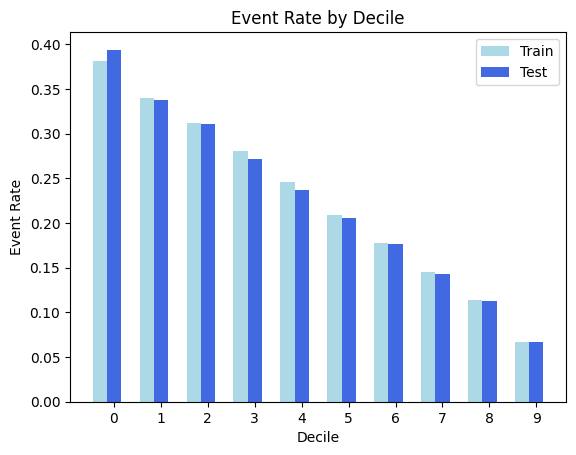

In [237]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()

Insight Final:
- O Modelo tem uma boa estabilidade, pois a barra de treino não está tão distante da barra de teste ao longo dos decis.
- O Modelo também tem um bom poder de ordenação, mostrando que conforme o score aumenta, a taxa de inadimplencia diminui.
- Porém, um KS de 0.243114 é uma performance baixa considerando benchmarking de mercado, e os primeiros decis não tem muita diferença do total de mal pagadores, variando entre 17% no decil 0 e 15% decil 1 por ex, o que mostra que existe grande oportunidade de melhorar a performance do algoritmo pois ele não está concentrando tantos clientes inadimplentes nos primeiros decis.

## Salvar melhor modelo

In [229]:
#salvando pickle do modelo para futura utilização.
import pickle

with open('vars_lgbm_1.pkl', 'wb') as f:
    pickle.dump(X_train_1_processed.columns, f)

with open('lgbm_1.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)